## Setup

In [1]:
# Get raw advent-of-code data
from aocd.models import Puzzle

puzzle = Puzzle(year=2025, day=11)
input_data = puzzle.input_data
example = puzzle.examples[0]

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from common.utils.perf_check import time_solution

## Part a


Counting the amount of unique paths through an acyclic graph can be easily solved with a depth-first search (DFS) algorithm.

In [3]:
# Functions
def parse_input(input_data: str) -> dict[str, list[str]]:
    """Parse the input data into a graph."""
    graph = {}
    for line in input_data.splitlines():
        node, downstream = line.split(":")
        graph.setdefault(node, []).extend(downstream.split())
    return graph


def count_paths_a(input_data: str, start: str = "you", end: str = "out") -> int:
    """Count all paths from start to end using DFS."""
    # Parse the input data into a graph
    graph = parse_input(input_data)

    def dfs(node: str, visited: set[str]) -> int:
        # Base case: reached the destination
        if node == end:
            return 1

        # Mark as visited to avoid cycles
        visited.add(node)

        # Count paths through all neighbors
        path_count = 0
        for neighbor in graph.get(node, []):
            if neighbor not in visited:
                path_count += dfs(neighbor, visited)

        # Backtrack: unmark for other paths
        visited.remove(node)

        return path_count

    # Start DFS from the starting node
    return dfs(start, set())

In [ ]:
# Correctness check (manual assertion because fetching expected answer failed)
count_paths_a(example.input_data) == 5

True

In [ ]:
# Performance check
time_a = time_solution(count_paths_a, input_data, iterations=500, runs=10, time_unit="us")
print(f"The DFS approach takes {time_a:.0f} μs per run.")

The DFS approach takes 345 μs per run.


In [ ]:
# Submit answers
puzzle.answer_a = str(count_paths_a(input_data))

That's the right answer!  You are one gold star closer to decorating the North Pole. [Continue to Part Two]


## Part b

Now we need to track more state during our DFS traversal. Specifically, we need to keep track of which required nodes have been visited so far. Caching our DFS results should keep the performance reasonable.

For smallish numbers of required nodes (let's say n < 16), we can use bitmasks to track which required nodes have been visited. Each required node is assigned a unique bit position, and we use an integer to represent the set of visited required nodes. When we visit a required node, we set the corresponding bit in our bitmask. At the end of our traversal, we check if all required nodes have been visited by comparing the bitmask against the sum of all required node bits.

In [16]:
# Imports
from functools import lru_cache

In [ ]:
# Functions
def count_paths_b(
    input_data: str, start: str = "srv", required_nodes: frozenset[str] = frozenset({"dac", "fft"}), end: str = "out"
) -> int:
    """Count paths from start to end that visit all required nodes using bitmask state tracking."""
    graph = parse_input(input_data)

    # Map each required node to a bit position
    req_to_bit = {node: 1 << i for i, node in enumerate(required_nodes)}

    # Determine the bitmask representing all required nodes visited
    all_req_nodes_mask = (1 << len(required_nodes)) - 1

    # Add memoization to optimize repeated state calculations
    @lru_cache(maxsize=min(len(graph) * (1 << len(required_nodes)), 1 << 10))  # Set a reasonable maxsize
    def dfs(node: str, visited_nodes_mask: int) -> int:
        """State is a bitmask: bit i set means req_list[i] has been visited."""
        if node == end:
            # Only count this path if all required nodes have been visited
            return 1 if visited_nodes_mask == all_req_nodes_mask else 0

        path_count = 0
        for neighbor in graph.get(node, []):
            # Update visited nodes mask if neighbor is a required node
            new_visited_nodes_mask = visited_nodes_mask | req_to_bit.get(neighbor, 0)
            path_count += dfs(neighbor, new_visited_nodes_mask)

        return path_count

    # Initialize state with any required nodes that match start
    initial_state = req_to_bit.get(start, 0)
    return dfs(start, initial_state)

In [65]:
# Manually create example for part B, as it was not fetched
example_b_input = """svr: aaa bbb
aaa: fft
fft: ccc
bbb: tty
tty: ccc
ccc: ddd eee
ddd: hub
hub: fff
eee: dac
dac: fff
fff: ggg hhh
ggg: out
hhh: out"""

In [ ]:
# Correctness check (manual assertion because fetching expected answer failed)
count_paths_b(example_b_input) == 2

True

In [ ]:
# Performance check
time_b = time_solution(count_paths_b, input_data, iterations=500, runs=10, time_unit="us")
print(f"The DFS approach takes {time_b:.0f} μs per run.")

The DFS approach takes 153 μs per run.


In [ ]:
puzzle.answer_b = count_paths_b(input_data)

That's the right answer!  You are one gold star closer to decorating the North Pole.You have completed Day 11! You can [Shareon
  Bluesky
Twitter
Mastodon] this victory or [Return to Your Advent Calendar].


### Bonus: Use the new function to solve part a
We can also use our new function to solve part a by simply passing an empty set of required nodes and changing the start node to "you". Let's see how much faster it is compared to our original DFS implementation.

In [ ]:
# Performance check
time_a_with_func_b = time_solution(
    count_paths_b, input_data, "you", frozenset({}), iterations=500, runs=10, time_unit="us"
)
print(f"The memoized DFS approach takes {time_a_with_func_b:.0f} μs per run for part A.")
print(f"This is {time_a / time_a_with_func_b:.1f} x faster than the non-memoized approach.")

The memoized DFS approach takes 185 μs per run for part A.
This is 1.9 x faster than the non-memoized approach.


### Bonus: Check performance with more than 2 required nodes
I'm curious how well this approach scales with more required nodes. Let's test it with more required nodes and see how the performance holds up.


In [ ]:
# Imports
from random import sample

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def plot_s_analysis_req_nodes(
    n_req_nodes_range: np.ndarray, times: np.ndarray, title: str = "Performance Analysis: Varying Required Nodes"
) -> None:
    """Plot the performance analysis results."""
    plt.figure(figsize=(10, 6))
    plt.plot(n_req_nodes_range, times, marker="o")
    plt.title(title)
    plt.xlabel("Number of Required Nodes")
    plt.ylabel("Average Execution Time (μs)")
    plt.grid(visible=True)
    plt.xticks(n_req_nodes_range)
    plt.show()
    plt.close()


def s_analysis_req_nodes(
    input_data: str, *, rand_runs_per_sample: int = 5, num_samples: int = 10, show_plot: bool = True
) -> tuple[np.ndarray, np.ndarray]:
    """Run a performance analysis varying the number of required nodes."""
    graph = parse_input(input_data)
    nodes = graph.keys()
    n_req_nodes_range = np.linspace(2, len(nodes), num_samples, dtype=int)
    times = []
    for i in n_req_nodes_range:
        time = 0
        for _ in range(rand_runs_per_sample):  # Average over multiple runs to ensure randomness is smoothed out
            required_nodes = frozenset(sample(sorted(nodes), i))
            time += time_solution(count_paths_b, input_data, required_nodes=required_nodes, time_unit="us")

        times.append(time / rand_runs_per_sample)

    # Convert to numpy array
    times = np.array(times)

    if show_plot:
        plot_s_analysis_req_nodes(n_req_nodes_range, times)

    return (n_req_nodes_range, times)

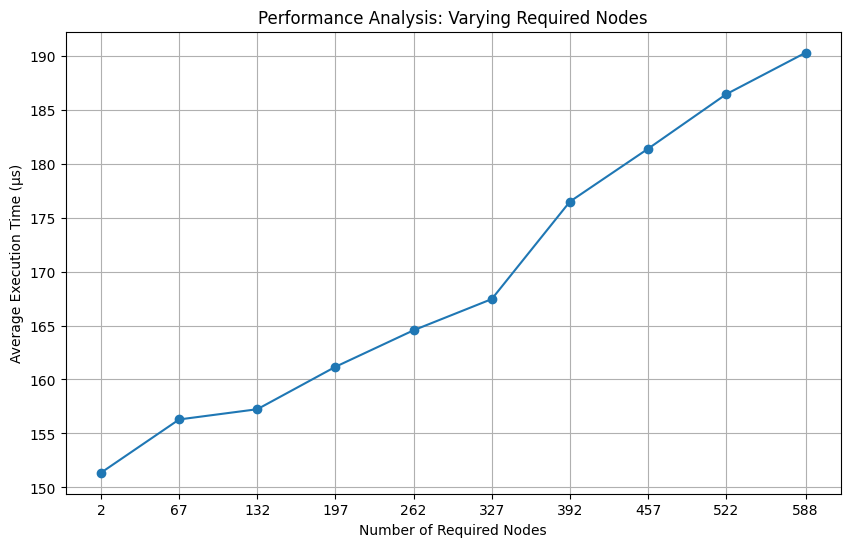

In [44]:
# Create plot
n_req_nodes_range, times = s_analysis_req_nodes(input_data, rand_runs_per_sample=10)

We can see that the run speed goes up slightly, but remains manageable for a reasonable number of required nodes, with an increase from ~150 μs for 2 required nodes to ~190 μs for 580 required nodes.


In [21]:
def multiply_graph(input_data: str, multiplier: int = 2) -> str:
    """Add more nodes to the graph by duplicating existing nodes with suffixes."""
    new_str = input_data
    node_addons = sample("abcdefghijklmnopqrstuvwxyz", k=multiplier - 1)
    protected_nodes = {"you", "out", "svr", "dac", "fft"}
    for line in input_data.splitlines():
        node, downstream = line.split(":")
        for addon in node_addons:
            new_str += f"\n{node}{addon}: {' '.join(d + addon for d in downstream.split() if d not in protected_nodes)}"
    return new_str

In [39]:
results = []
for i in range(2, 25):
    multiplied_input = multiply_graph(input_data, multiplier=i)
    results.append(
        (
            len(multiplied_input.splitlines()),
            time_solution(count_paths_a, multiplied_input),
            time_solution(count_paths_b, multiplied_input, required_nodes=frozenset({})),
        ),
    )

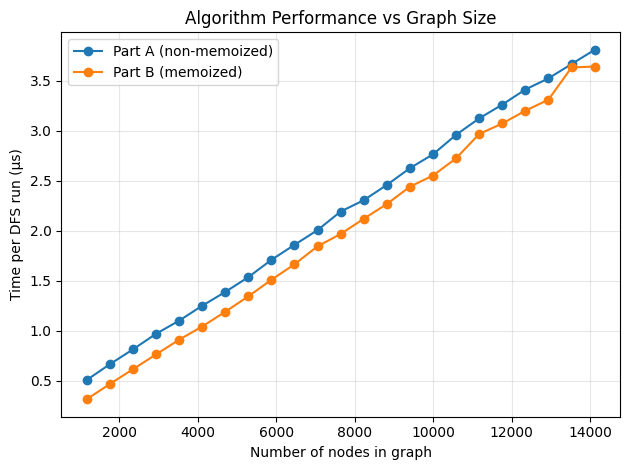

In [42]:
# Create plot
lines, times_a, times_b = zip(*results, strict=True)
plt.figure()
plt.plot(lines, times_a, marker="o", label="Part A (non-memoized)")
plt.plot(lines, times_b, marker="o", label="Part B (memoized)")
plt.xlabel("Number of nodes in graph")
plt.ylabel("Time per DFS run (μs)")
plt.title("Algorithm Performance vs Graph Size")
plt.legend()
plt.grid(visible=True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

We can see that the run speed grows linearly with the graph size. Interesting is that the non-memoized version also grows linearly with the same slope.

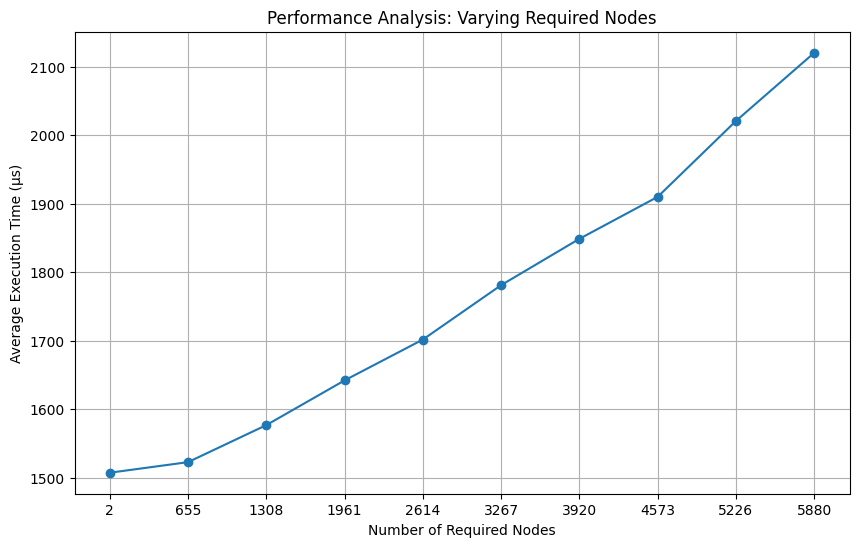

In [45]:
multiplied_input = multiply_graph(input_data, multiplier=10)
n_req_nodes_range, times = s_analysis_req_nodes(multiplied_input)

Finally, we can see the algorithm speeds grows linearly, even for graphs 10 times larger than the original input graph. It is safe to assume that this behavior scales similarly for even larger graphs